

Salma ELMIZ <br>
Tommaso McPhee <br>
Ziyad Benkhadaj

In [1351]:
import numpy as np
import matplotlib.pyplot as plt   
import time 

## *****Preliminaries*****


### Generation of input bits

In [1307]:
def source(N, p):  # generates a nb-long array of 0s and 1s, p is the probability of a 0, 1-p of a 1
    b = [1]*N # b is filled with ones by default
    for j in range(N):
        x = np.random.rand()  # generates a number uniformly between 0(included) and 1(excluded)
        if x < p:
            b[j] = 0

    return b

Let's generate a sequence of bits of length:<br>  N = 12 <br> p = 0.5


In [1308]:
print(" b =", source(10, 0.5))

 b = [1, 1, 1, 1, 0, 0, 0, 1, 0, 0]


### Generation of an M-QAM(=4, 16, 64, 256...) square constellation with gray-mapping 


In [1309]:
def closest_divisors(M):
    p = int(np.sqrt(M))
    while M % p > 0:
        p = p - 1

    return p, M//p

def generate_constellation(M, E): # returns an M-QAM constellation with mean energy E
    p, q = closest_divisors(M)
    pam_real = np.arange(0, q) * 2 - (q - 1)
    pam_imaginary = -(np.arange(0, p) * 2 - (p - 1))
    const = np.zeros((p,q)) * 1j
    for k in range(p):
        for l in range(q):
            const[k, l] = (pam_real[l] + 1j * pam_imaginary[k])

    avg_nrj = np.average(np.abs(const) ** 2)
    const = const * np.sqrt(E / avg_nrj)

    return const

def generate_gray_mapping(N):
    return [i ^ (i >> 1) for i in range(N)]

### Example of use

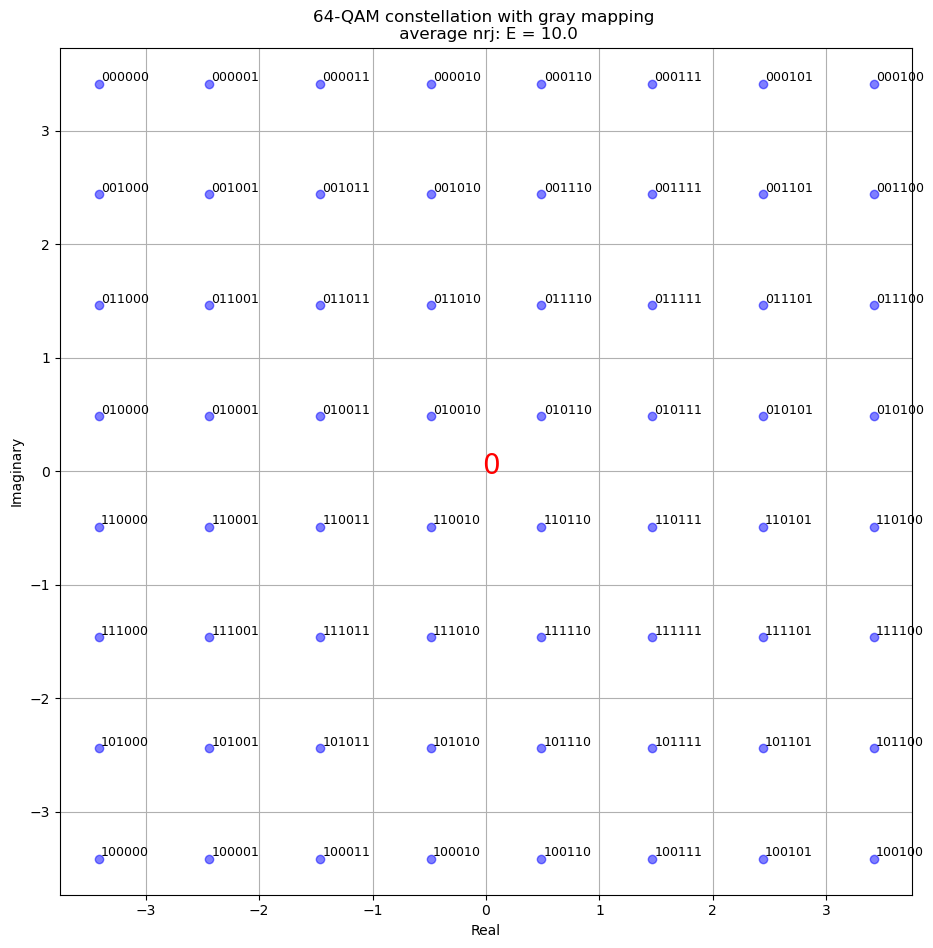

In [1310]:
M = 64
p, q = closest_divisors(M)
E = 10
cnt = generate_constellation(M, E)

gray_mapping_x = generate_gray_mapping(q)
gray_mapping_y = generate_gray_mapping(p)
cnt_1D = np.ravel(cnt)


# Plot the constellation points
plt.figure(figsize=(11, 11))
plt.scatter(np.real(cnt_1D), np.imag(cnt_1D), color='blue', alpha=0.5)


# Set plot limits and labels
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid(True)
plt.axis('equal')



for i in range(p):
    for j in range(q):
        point = cnt[i,j]
        bit_chunk_x = format(gray_mapping_x[j], '0'+str(round(np.log2(q)))+'b')
        bit_chunk_y = format(gray_mapping_y[i], '0'+str(round(np.log2(p)))+'b')
        bit_chunk = bit_chunk_y + bit_chunk_x
        plt.text(point.real + 0.02, point.imag + 0.02, bit_chunk, fontsize=9)
       
    
plt.text(-0.03, -0.027, "0", fontsize = 20, color="red")
val = np.average(np.abs(cnt)**2)
val = str(int(100*val)/100)
plt.title(str(M) + '-QAM constellation with gray mapping' + ' \n average nrj: E = ' + val)
plt.show()


## *****Effects of dispersion and non-linearity*****

### Some functions

In [1311]:


def dispersion(t, q_input, z, beta2): # we suppoe q_input  
    dt = t[1] - t[0]  # time step
    f = np.fft.fftfreq(len(t), dt)  # zero frequency first, then positive frequencies then negative frequencies
    x = q_input.copy()
    qf_input = np.fft.fft(np.fft.ifftshift(x))  # computes the fourier transform (to a constant close)
    qf_output = qf_input * np.exp(1j * beta2 * 0.5 * ((2 * np.pi * f) ** 2) * z)

    return np.fft.fftshift(np.fft.ifft(qf_output))  ## begins at time 0


def non_linear(q_input, z, gamma):
    return q_input * np.exp(1j * gamma * z * np.abs(q_input) ** 2)


def channel(t, q_input, z, beta2, gamma, nz=100):  ## applies the linear then non linear operator nz times
    x = q_input.copy()
    dz = z / nz

    for k in range(nz):                    #symmetric SSFM
        x = non_linear(x, dz/2, gamma)
        x = dispersion(t, x, dz, beta2)
        x = non_linear(x, dz/2, gamma)

    return x


def gaussian_pulse(t, a=1):
    return a * np.exp(-t ** 2 / 2)


### Case of dispersion only

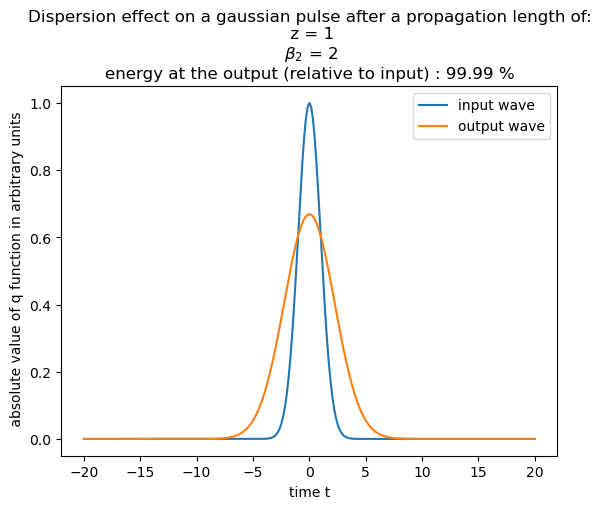

In [1312]:

## case of dispersive and linear channel

N = int(2**8) + 1
T  = 40
t = np.linspace(-T/2, T/2, N)
q_input = gaussian_pulse(t)
z = 1
beta2 = 2



q_output = dispersion(t, q_input, z, beta2)

plt.figure()
plt.plot(t, np.abs(q_input), label = "input wave")
plt.plot(t, np.abs(q_output), label = "output wave")
plt.legend(loc= "best")
nrj_input = np.sum(q_input**2) 
nrj_output = np.sum(np.abs(q_output)**2) 
text = ("Dispersion effect on a gaussian pulse after a propagation length of:\n z = "+ str(z)+ "\n" + r" $\beta_2$ = " +
       str(beta2)  +" \n" + "energy at the output (relative to input) : " +
       str(nrj_output/nrj_input *100)[:5] + " %" )

plt.title(text)
plt.xlabel("time t")
plt.ylabel(" absolute value of q function in arbitrary units")
plt.show()

### Case of non-linearity only

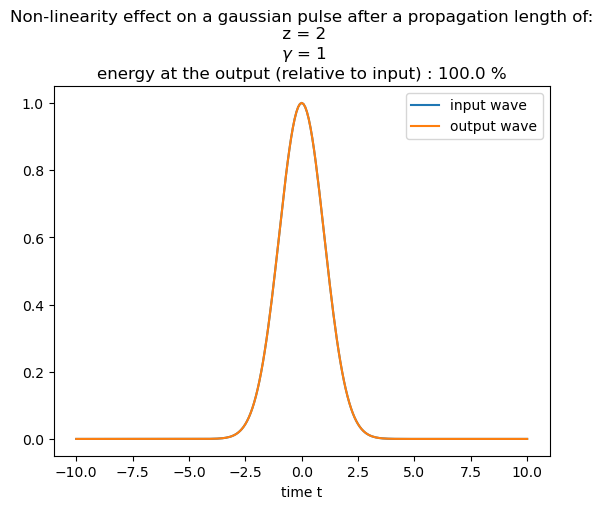

In [1313]:
N = int(2**8) + 1
T  = 20
t = np.linspace(-T/2, T/2, N)
z = 2
gamma = 1


q_input = gaussian_pulse(t)
q_non_linear = non_linear(q_input, z , gamma )

plt.figure()
plt.plot(t, np.abs(q_input), label = "input wave")
plt.plot(t, np.abs(q_non_linear), label = "output wave")
plt.legend(loc= "best")
nrj_input = np.sum(q_input**2) 
nrj_output = np.sum(np.abs(q_non_linear)**2) 
text = ("Non-linearity effect on a gaussian pulse after a propagation length of:\n z = "+ str(z)+ "\n" + r" $\gamma$ = " +
       str(gamma)  +" \n" + "energy at the output (relative to input) : " +
       str(nrj_output/nrj_input *100)[:5] + " %" )

plt.title(text)
plt.xlabel("time t")
plt.show()


Note here that energy is pulse shape is conserved since non-linearity corresponds to only adding a phase shift to the wave

### Effect of both non-linearity and dispersion 

### Case of a soliton with UNMATCHING non-linearity and dispersion

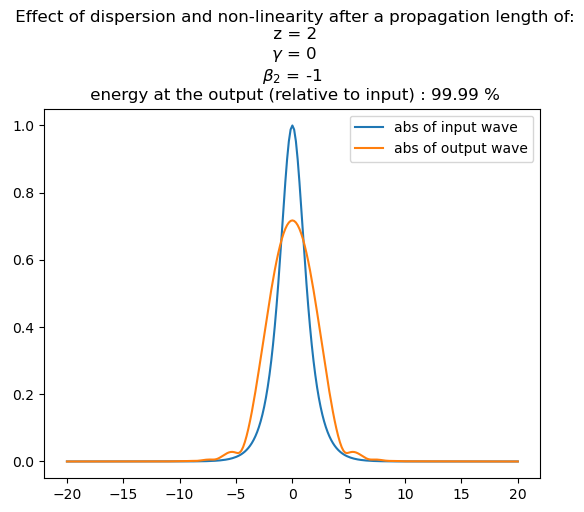

In [1314]:

## case of both

N = int(2**8) + 1
T  = 40
t = np.linspace(-T/2, T/2, N)
z = 2
beta2 = -1
gamma = 0

#q_input = gaussian_pulse(t)
q_input = 1/np.cosh(t)

q_output = channel(t, q_input, z, beta2, gamma, nz = 1000)
nrj_input = np.sum(q_input**2) 
nrj_output = np.sum(np.abs(q_output)**2) 

plt.figure()
plt.plot(t, np.abs(q_input), label = "abs of input wave")
plt.plot(t, np.abs(q_output), label = "abs of output wave")
plt.title(" Effect of dispersion and non-linearity after a propagation length of:\n z = "+ str(z)+ "\n" + r" $\gamma$ = " +
       str(gamma)  +" \n" + r"$\beta_2$ = " + str(-1) + "\n energy at the output (relative to input) : " +
       str(nrj_output/nrj_input *100)[:5] + " %" )
plt.legend(loc= "best")
plt.show()

### Case of a soliton with MATCHING non-linearity and dispersion

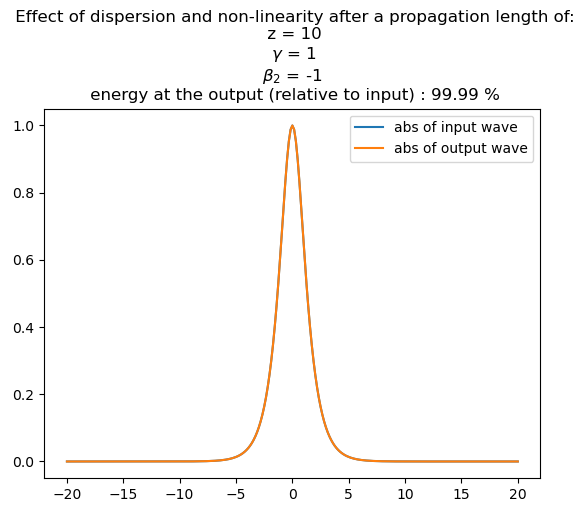

In [1315]:
## case of both

N = int(2**8) + 1
T  = 40
t = np.linspace(-T/2, T/2, N)
z = 10
beta2 = -1
gamma = 1

#q_input = gaussian_pulse(t)
q_input = 1/np.cosh(t)

q_output = channel(t, q_input, z, beta2, gamma, nz = 1000)
nrj_input = np.sum(q_input**2) 
nrj_output = np.sum(np.abs(q_output)**2) 

plt.figure()
plt.plot(t, np.abs(q_input), label = "abs of input wave")
plt.plot(t, np.abs(q_output), label = "abs of output wave")
plt.title(" Effect of dispersion and non-linearity after a propagation length of:\n z = "+ str(z)+ "\n" + r" $\gamma$ = " +
       str(gamma)  +" \n" + r"$\beta_2$ = " + str(-1) + "\n energy at the output (relative to input) : " +
       str(nrj_output/nrj_input *100)[:5] + " %" )
plt.legend(loc= "best")
plt.show()

## *****Part on animation: c.f the animation python file, where you can change the parameters and simulate propagation of waves in a dispersive and/or non-linear channel*****

c.f. animation.py

## *****Part on simulating a communication system*****

### Gray bit mapping from and to symbols

In [1316]:

    
def bit_chunk_to_symbol(bit_chunk, const):  # maps a bit chunk to a symbol from the constellation const
    k = len(bit_chunk)
    M = round(2**k)
    p, q = closest_divisors(M)
    limit = round(np.log2(p))
    bit_chunk_x = bit_chunk[limit:]
    bit_chunk_y = bit_chunk[:limit]


    gray_mapping_x = generate_gray_mapping(q)
    gray_mapping_y = generate_gray_mapping(p)

    symbol_index_x = 0
    for bit in bit_chunk_x:
        symbol_index_x = (symbol_index_x << 1) | bit

    symbol_index_y = 0
    for bit in bit_chunk_y:
        symbol_index_y = (symbol_index_y << 1) | bit

    j = gray_mapping_x.index(symbol_index_x)
    i = gray_mapping_y.index(symbol_index_y)

    return const[i,j]

def number_to_bit_chunk(number, k):  # transforms a decimal number into a list of k elements corresponding to the binary representation of that number
    binary_number = bin(number)[2:]
    bit_chunk = list(binary_number)
    bit_chunk = [int(elem) for elem in bit_chunk]
    for i in range(k-len(bit_chunk)):
        bit_chunk = [0] + bit_chunk
        
    return bit_chunk

def symbol_to_bit_chunk(symbol, const):  #maps a symbol to a bit-chunk in the const
    M = np.size(const)
    k = round(np.log2(M))
    i = -1
    condition = True
    while i< M-1 and condition:  # the idea is to try every bit-chunk candidate to see if it matches the symbol
        i = i + 1
        bit_chunk_candidate = number_to_bit_chunk(i, k)
        symbol_candidate = bit_chunk_to_symbol(bit_chunk_candidate, const) 
        condition = (symbol  != symbol_candidate)
        
    return bit_chunk_candidate
    
    
    

#### Example of usage

In [1317]:
# Example usage:
M = 64
k = round(np.log2(M))
print("Constellation used: " + str(M) + "-QAM")
p, q = closest_divisors(M)
E = 1
cnt = generate_constellation(M, E)


bit_chunk = source(k, 0.5)
symbol = bit_chunk_to_symbol(bit_chunk, cnt)
print("Symbol corresponding to bit sequence {} is : {:.2f}".format(bit_chunk, symbol))
#print(" energy of the symbol = ", np.abs(symbol)**2)

print("\n ? can it find the bit chunk used to generate that symbol ? \n answer is : \n")

bit_chunk = symbol_to_bit_chunk(symbol, cnt)
print("bit chunk corresponding to symbol {:.2f} is : {}".format(symbol, bit_chunk))


Constellation used: 64-QAM
Symbol corresponding to bit sequence [0, 0, 1, 1, 1, 0] is : 0.15+0.77j

 ? can it find the bit chunk used to generate that symbol ? 
 answer is : 

bit chunk corresponding to symbol 0.15+0.77j is : [0, 0, 1, 1, 1, 0]


### Some useful functions

#### Modulation

In [1318]:
def soliton(x):
    return 1/np.cosh(x)


def mod(t, s, B, pulse=np.sinc):
    n = len(s)
    l1 = -int(np.floor(n / 2))
    l2 = int(np.ceil(n / 2)) - 1
    q = np.zeros(len(t))
    for l in range(l1, l2 + 1):
        q = q + s[l - l1] * pulse(B * t - l)  

    return q * np.sqrt(B)  # the sqrt(B) is to normalize



#### Demodulation

In [1319]:
def demod(t, qzte, B, n_exp, pulse = np.sinc): #n_exp is the number of expected symbols
    dt = np.abs(t[1] - t[0])
    l1 = -int(np.floor(n_exp / 2))
    l2 = int(np.ceil(n_exp / 2)) - 1
    s_hat = np.ones(n_exp)*1j
    for l in range(l1, l2 + 1):
        s_hat[l-l1] = np.dot(qzte, pulse(B*t - l))

    return  s_hat * np.sqrt(B) * dt

#### Detector

In [1320]:
def closest_symbol(symb, cnt): # looks, in cnt, for the closest symbol to symb
    distances = np.abs(cnt - symb)
    min_index = np.unravel_index(np.argmin(distances), distances.shape)

    return cnt[min_index]


def detector(s_hat, const): #decides, given s_hat, for the closest symbol in the constellation
    n = len(s_hat)
    s_tilde = np.zeros(n)*1j
    for l in range(n):
        s_tilde[l] = closest_symbol(s_hat[l], const)

    return s_tilde

#### FEC coding functions

In [1321]:
def hamming_encode(L):  ## encodes sequence of bits according to the hamming 7,4 ECC
    res = []
    for i in range(len(L)//4):
        bit_chunk = L[4*i: 4*(i+1)]
        parity_1 = (bit_chunk[0] + bit_chunk[1] + bit_chunk[2])%2
        parity_2 = (bit_chunk[1] + bit_chunk[2] + bit_chunk[3])%2
        parity_3 = (bit_chunk[2] + bit_chunk[3] + bit_chunk[0])%2
        res = res + bit_chunk + [parity_1, parity_2, parity_3]
        
    return res


def is_error_free(bit_chunk):  #checks if the 7 bits chunk is respecting the parity check conditions or no
    parity_1 = (bit_chunk[0] + bit_chunk[1] + bit_chunk[2])%2
    parity_2 = (bit_chunk[1] + bit_chunk[2] + bit_chunk[3])%2
    parity_3 = (bit_chunk[2] + bit_chunk[3] + bit_chunk[0])%2
    
    if (parity_1 == bit_chunk[4]) and (parity_2 == bit_chunk[5]) and (parity_3 == bit_chunk[6]):
        return True
    else:
        return False
    

def hamming_decode(L):  #decodes the encoded bits, and corrects any existing errors
    res = []
    for i in range(len(L)//7):
        bit_chunk = L[7*i: 7*(i+1)]
        j = -1
        while (j < 6) and not(is_error_free(bit_chunk)):
            if j> -1:
                bit_chunk[j] = (bit_chunk[j]+1)%2
            j = j+1
            bit_chunk[j] = (bit_chunk[j]+1)%2
            
        res = res + bit_chunk[:4]
        
    return res

In [1322]:
aa = [0, 0, 1, 0]*2
print(" original =        ", aa)


bb = hamming_encode(aa)
print(" encoded =         ", bb)


j = 13 #error on index j
print(" assume there is an error at index : ", j, " of the encoded sequence")
bb[j] = (1+bb[j])%2

print(" errored encoded = ", bb)
cc = hamming_decode(bb)

print(" does it correct the error ?:")

print(" errors after decoding =         ", [(cc[k] - aa[k])%2 for k in range(len(aa))])

 original =         [0, 0, 1, 0, 0, 0, 1, 0]
 encoded =          [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1]
 assume there is an error at index :  13  of the encoded sequence
 errored encoded =  [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0]
 does it correct the error ?:
 errors after decoding =          [0, 0, 0, 0, 0, 0, 0, 0]


## *****Test of the communication system*****

### Generation of a random TX bit sequence of length N_bits

In [1323]:
# bits management
N_bits = 3360  #number of bits used. For technical reasons, it should be a multiple of 3360 (so that it can be used for all constellations)
b = source(N_bits, 0.5) #generation of a random sequence of equally likely bits



### FEC coding
The code used here is: Hamming(7,4)

In [1324]:

b_FEC_coded = hamming_encode(b)   ## FEC coding
#b_FEC_coded = b                    ## no FEC coding 

### Choice of the constellation used and energy used per symbol

In [1325]:
# constellation management
M = 4  #constellation size
k = round(np.log2(M))
E = 2
cnt = generate_constellation(M, E)


### Time and spectral management

In [1326]:
# time management
time_samples_per_symbol = 20
N_time = round(2*(N_bits/k *2) * time_samples_per_symbol)  
print(" Number of time samples used : N_time = ", N_time)
T = 100
t = np.linspace(-T/2, T/2, N_time)
dt = (t[1] - t[0])

# bandwidth 
B = 2*(N_bits/k*2)/T
print(" Symbol rate : B = ", B)

 Number of time samples used : N_time =  134400
 Symbol rate : B =  67.2


### Modulation at TX

In [1327]:
k = round(np.log2(M))
list_of_bit_chunks = [ [int(elem) for elem in b_FEC_coded[x*k:(x+1)*k]] for x in range(len(b_FEC_coded)//k) ]
s = np.array([bit_chunk_to_symbol(elem, cnt) for elem in list_of_bit_chunks]) # sent symbols

#pulse = soliton  #otherwise, it's a sinc by default
pulse= np.sinc

signal_TX = mod(t, s, B, pulse)

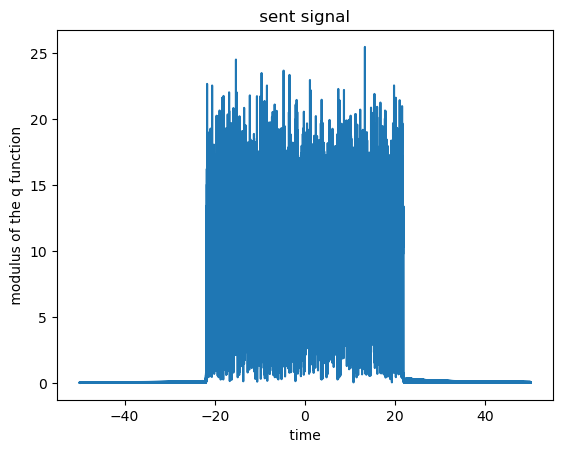

In [1328]:
# Plotting of the sent signal

plt.plot(t, np.abs(signal_TX))
plt.title(" sent signal ")
plt.xlabel(" time ")
plt.ylabel(" modulus of the q function ")
plt.show()



### Channel (potentially + noise)

In [1329]:
# parameters of the fiber
beta2 = -1
gamma = 1

# space management

N_space = int(1e4) #number of space samples
z = 1 # propagation distance
Z = np.linspace(0, z, N_space)
dz = (Z[1] - Z[0])
nz = int(1e4)

# noise

def noise(N, N0): # generates a N long sequence of AWGN noise with mean 0 and variance N0
    return np.sqrt(N0/2) * (np.random.randn(N) + 1j*np.random.randn(N))

SNR_dB = 7   # dB

SNR = 10**(SNR_dB/10)


signal_RX = channel(t, signal_TX, z, beta2, gamma, nz)     + noise(len(signal_TX), E/SNR)

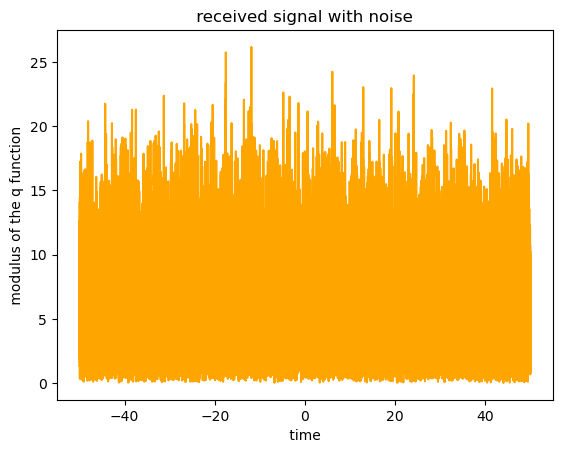

In [1330]:
# Plotting of the received signal

plt.plot(t, np.abs(signal_RX), color= 'orange')
plt.title(" received signal with noise ")
plt.xlabel(" time ")
plt.ylabel(" modulus of the q function ")
plt.show()


### Equalization

In [1331]:
signal_RX_equalized = channel(t, signal_RX, -z, beta2, gamma, nz)

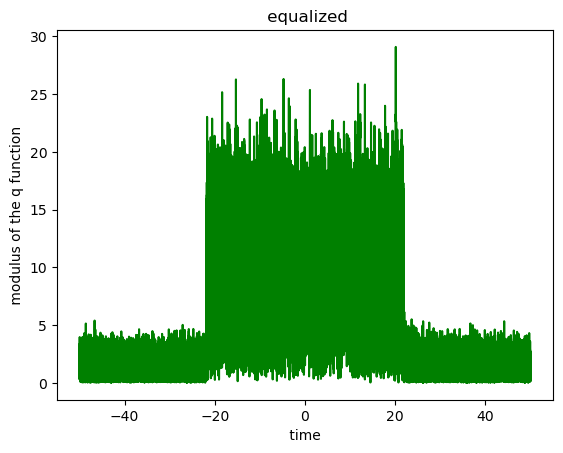

In [1332]:
# Plotting of the equalized signal

plt.plot(t, np.abs(signal_RX_equalized), color= 'green')
plt.title(" equalized")
plt.xlabel(" time ")
plt.ylabel(" modulus of the q function ")
plt.show()


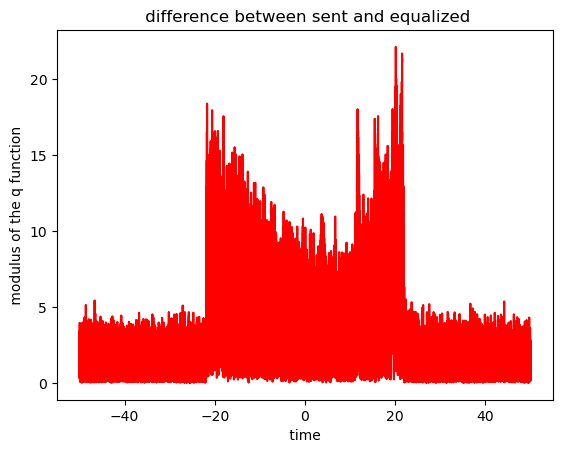

In [1333]:
# Plotting of the difference between the two signals

plt.plot(t, np.abs(signal_RX_equalized - signal_TX), color= 'red')
plt.title(" difference between sent and equalized")
plt.xlabel(" time ")
plt.ylabel(" modulus of the q function ")
plt.show()


### Demodulation at RX

In [1334]:
s_hat = demod(t, signal_RX_equalized , B, len(s))  


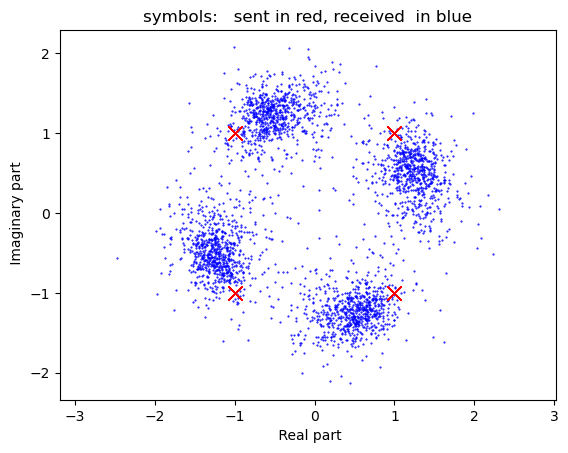

In [1335]:
# Plotting of the constellation of symbols sent and received
    
for elem in s_hat:
    plt.plot(elem.real, elem.imag,'.', ms=1, color = "blue")
    
for elem in s:
    plt.plot(elem.real, elem.imag,'x', ms=10, color = "red")
    
plt.title("symbols:   sent in red, received  in blue")
plt.xlabel(" Real part")
plt.ylabel(" Imaginary part")
plt.axis("equal")
plt.show()
    

The colored noise (resulting from the equalization process) will affect the ML decision and minimal decision criterion. <br> This will add a phase to the symbols which is inversely proportionnal to the SNR. <br> This can be undone with a manual phase shift of the symbols determined empirically (depending on the constellation, SNR...).


In [1336]:
theta = 10/SNR*np.pi/180   *   (10) #degrés
s_hat = s_hat * np.exp(1j * theta)

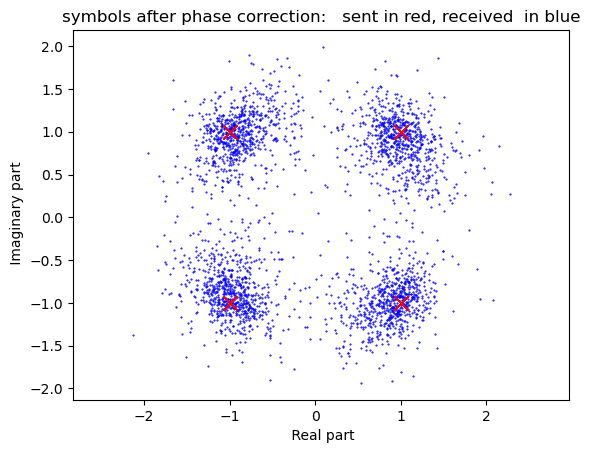

In [1348]:
# Plotting of the constellation of symbols sent and received after treatement
    
for elem in s_hat:
    plt.plot(elem.real, elem.imag,'.', ms=1, color = "blue")
    
for elem in s:
    plt.plot(elem.real, elem.imag,'x', ms=10, color = "red")
    
plt.title("symbols after phase correction:   sent in red, received  in blue")
plt.xlabel(" Real part")
plt.ylabel(" Imaginary part")
plt.axis("equal")
plt.show()

### Detection of symbols

In [1338]:
s_tilde = detector(s_hat, cnt)

### Converting symbols to bits

In [1339]:
bit_chunks_received = [ symbol_to_bit_chunk(elem, cnt) for elem in s_tilde ]
bits_received = []
for elem in bit_chunks_received:
    bits_received = bits_received + elem

### Decoding of FEC

In [1340]:
bits_received_FEC_decoded = hamming_decode(bits_received)   ## if FEC coding
#bits_received_FEC_decoded = bits_received                   ## if no FEC coding 

In [1341]:
errors = [np.abs(b[i] - bits_received_FEC_decoded[i]) for i in range(len(b))]



In [1342]:
print(len(b_FEC_coded))

5880


### BER performance

In [1343]:
BER = np.sum(errors)/len(errors)
print(" BER = ", int(1e5*BER)/1e3 , " %") # show 3 decimal digits after .

print(" number of errors = ", np.sum(errors))

 BER =  0.446  %
 number of errors =  15


In [1350]:
print(" SNR in dB = ",SNR_dB)

 SNR in dB =  7


In [1345]:
## Collect of BERs

In [1346]:
SNR_in_dB = [ 3      ,  5   ,   7     ,  8       ,  9     , 10    , 11     , 12   , 13   , 14]

v = 1e-2   # I take 0.01% for an error free so that the plot in the next figure is nice

BER_M4    = [ 3.857  , 1.6  ,   0.565 ,  0.38    , 0.148  , 0.029 , v      , v    , v    , v] #in percentage, i.e (x1e-2)
BER_M8    = [ 4.61   , 2.66 ,   0.625 ,  0.44    , 0.267  , 0.059 , v      , v    , v    , v]
BER_M16   = [ 48     , 49   ,   12    ,  2.38   , 0.922  , 0.178 , 0.148  , 0.178, 0.119, v]                   





BER_M4    = [elem*0.01 for elem in BER_M4] 
BER_M8    = [elem*0.01 for elem in BER_M8] 
BER_M16    = [elem*0.01 for elem in BER_M16] 

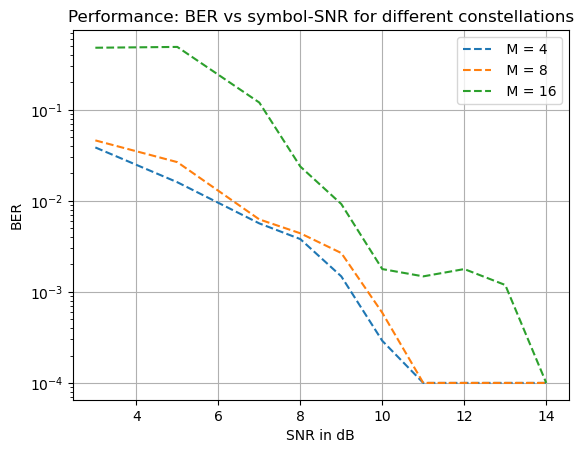

In [1347]:
plt.plot(SNR_in_dB, BER_M4 ,'--', label =" M = 4")
plt.plot(SNR_in_dB, BER_M8 ,'--', label =" M = 8")
plt.plot(SNR_in_dB, BER_M16,'--', label =" M = 16")

plt.xlabel("SNR in dB")
plt.ylabel("BER")
plt.yscale('log')
plt.grid()
plt.title("Performance: BER vs symbol-SNR for different constellations")
plt.legend(loc="best")
plt.show()

